# 3.5.3 [Boosting Guided Example & Challenge](https://courses.thinkful.com/data-201v1/project/3.5.3)

In [49]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Drill: Improve the Gradient boost model by:
* creating new features
* applying overfitting prevention strategies like subsampling
* more iterations
* try different loss function
* change structure of the weak learner: allow more leaves in the tree or other modification

# Gradient Boost Guided Example
Whether or not someone lives with a partner

In [17]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.

X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test test.
X_test, y_test = X[offset:], y[offset:]

In [22]:
y.value_counts()

0.0    5013
1.0    3134
Name: partner, dtype: int64

### Binary outcome will require different loss function. Could use "deviance" or "exponential" Deviance is used for logistic regression so we use that here

### Below I created a function to loop through options for each parameter. You do have to manually change which parameter you are adjusting so its more complicated than it should be but it helped me lay it out for myself.

#### It looks like a model with max depth of 2 or 3 

In [75]:
# WE'll make 500 iterations, use 2-deep trees, and set our loss function.


def param_test(parameter_name, param_min, param_max, param_step):
    parameter_values = []
    evaluation_metric_train = []
    evaluation_metric_test = []
    
    for x in np.arange(param_min, param_max, param_step):
        parameter_values.append(x)
        
        params = {parameter_name: x,
          #'n_estimators': 100,
          'max_depth': 3,
          'loss': 'deviance',
          'subsample': 0.5}
        
        # Initialize and fit model
        model_instance = ensemble.GradientBoostingClassifier(**params)
        model_instance.fit(X_train, y_train)
        
        evaluation_metric_train.append(model_instance.score(X_train, y_train))
        evaluation_metric_test.append(model_instance.score(X_test, y_test))
        
    # Make the data pretty
    df_output = pd.DataFrame(data={parameter_name:parameter_values, 
                                   'train_score':evaluation_metric_train, 
                                   'test_score':evaluation_metric_test})
    df_output = df_output.sort_values(by=parameter_name, ascending=True)
    
    # Plot line for each Parameter
    plt.plot(df_output[parameter_name], df_output['train_score'], label='train')
    plt.plot(df_output[parameter_name], df_output['test_score'], label='test')
    plt.xlabel('Parameter Values')
    plt.ylabel('Evaluation Metric')
    plt.ylim(0.5,0.9)
    plt.title(parameter_name)
    plt.show()
    

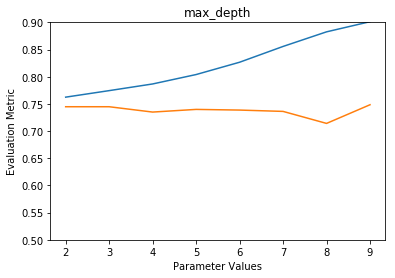

In [71]:
param_test('max_depth',2,10,1)

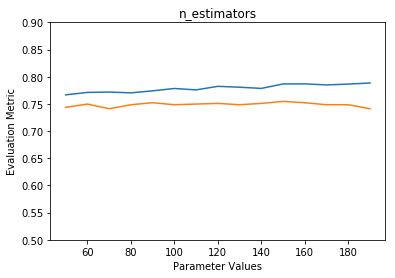

In [76]:
param_test('n_estimators', 50, 200, 10)

# ^Looks like difference between in sample and out of sample accuray starts to grow after 170 iterations

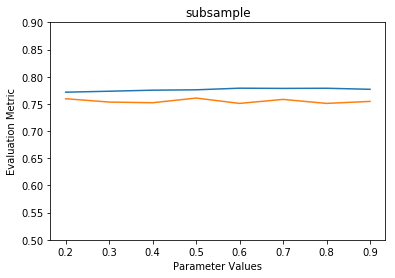

In [73]:
param_test('subsample', 0.2, 1, 0.1)

# ^ I'm seeing distance 0.2 or 0.5 being best subsampling size for controlling overfit

In [14]:
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0]/table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']


print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


### Can get a sense of how important features are by counting how many times a feature is used over the course of many decision trees.

In [77]:
params = {'n_estimators': 150,
          'max_depth': 3,
          'loss': 'deviance',
          'subsample': 0.5}
        
        # Initialize and fit model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
        

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

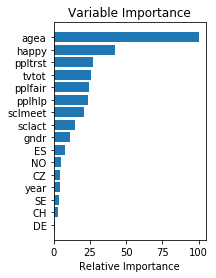

In [78]:
feature_importance = clf.feature_importances_

#  Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()